In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import seaborn as sns
sns.set(style="whitegrid")

import fiona
import fiona.crs
import shapely
import rtree

import pandas as pd
import geopandas as gpd

In [5]:
# This is to load the shape file
shapefile = 'ZillowNeighborhoods-NY/ZillowNeighborhoods-NY.shp'

# And project it into EPSG:2263 (NAD 83 NY State) plane
neighborhoods = gpd.read_file(shapefile).to_crs(fiona.crs.from_epsg(2263))

In [6]:
neighborhoods.head()

STATE    COUNTY                     CITY             NAME  REGIONID  \
0    NY    Monroe                Rochester  Ellwanger-Barry  343894.0   
1    NY  New York  New York City-Manhattan     West Village  270964.0   
2    NY     Kings   New York City-Brooklyn      Bensonhurst  193285.0   
3    NY      Erie                  Buffalo       South Park  270935.0   
4    NY  New York  New York City-Manhattan     East Village  270829.0   

                                            geometry  
0  POLYGON ((19805.35711778845 1099961.05355486, ...  
1  POLYGON ((980372.9910645633 205202.4799663476,...  
2  POLYGON ((978233.4712775955 159030.8800673813,...  
3  POLYGON ((-311815.6157876701 1012190.261676005...  
4  POLYGON ((987758.593831465 206590.82743873, 99...

In [7]:
# We construct an R-Tree by going through the geometries of the
# shapefiles (i.e. the polygons in the 'geomtry' column). We only 
# use the bounds, not the actual geometry, and the key for each 
# bound is the index into the neighborhood name
index = rtree.Rtree()
for idx,geometry in enumerate(neighborhoods.geometry):
    index.insert(idx, geometry.bounds)

In [8]:
# This is the bounding box of all neighborhoods (in NAD 83 projection)
index.bounds

[-331110.02592820046,
 119967.03773856077,
 1067432.6651321745,
 1150191.636787515]

In [9]:
# The code below will go through the greentaxi.csv file, and:
# (1) Select the trips happened between 10a and 11a.
# (2) Map pick-up locations to neighborhoods using the index above
# (3) Count the trips per neighborhood

import csv
import pyproj
import shapely.geometry as geom


proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    

counts = {}
with open('green.csv', 'r') as fi:
    reader = csv.reader(fi)
    print(next(reader)) # Skip the header
    for row in reader:
        print(row)
        pdt = row[0].split(' ')[1].split(':')[0]
        if pdt!='10': continue # skip all records != around 10:xx pickup
        p = geom.Point(proj(float(row[3]), float(row[2])))
        match = None
        for idx in index.intersection((p.x, p.y, p.x, p.y)):
            # idx is in the list of shapes that might match
            if neighborhoods.geometry[idx].contains(p):
                match = idx
                break
        if match:
            counts[match] = counts.get(match, 0) + 1

['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
['2015-02-01 00:00:00.0', '2015-02-01 00:00:00.0', '40.762928009033203', '-73.933815002441406', '40.812656402587891', '-73.956741333007812']
['2015-02-01 00:00:00.0', '2015-02-01 00:27:52.0', '40.71795654296875', '-73.957534790039062', '40.677581787109375', '-73.912086486816406']
['2015-02-01 00:00:01.0', '2015-02-01 00:18:27.0', '40.715862274169922', '-73.961990356445312', '40.716781616210938', '-74.012161254882812']
['2015-02-01 00:00:02.0', '2015-02-01 00:07:28.0', '40.8265380859375', '-73.943130493164062', '40.808845520019531', '-73.944831848144531']
['2015-02-01 00:00:03.0', '2015-02-01 00:28:27.0', '40.802326202392578', '-73.9503173828125', '40.752830505371094', '-73.977737426757812']
['2015-02-01 00:00:04.0', '2015-02-01 00:09:16.0', '40.788005828857422', '-73.955673217773438', '40.775993347167969', '-73.944053649902344']
['2015-02-01 00:00:06.0', '20

['2015-02-01 00:32:14.0', '2015-02-01 00:42:26.0', '40.773994445800781', '-73.918899536132812', '40.757144927978516', '-73.884666442871094']
['2015-02-01 00:32:16.0', '2015-02-01 00:53:47.0', '40.664287567138672', '-73.990730285644531', '40.776920318603516', '-73.916397094726562']
['2015-02-01 00:32:16.0', '2015-02-01 00:41:15.0', '40.811576843261719', '-73.946701049804688', '40.790069580078125', '-73.93975830078125']
['2015-02-01 00:32:16.0', '2015-02-01 00:45:12.0', '40.736518859863281', '-73.955223083496094', '40.736274719238281', '-73.871505737304688']
['2015-02-01 00:32:17.0', '2015-02-01 00:38:03.0', '40.79449462890625', '-73.944747924804688', '40.792232513427734', '-73.950485229492188']
['2015-02-01 00:32:17.0', '2015-02-01 00:35:31.0', '40.775581359863281', '-73.911582946777344', '40.771217346191406', '-73.9036865234375']
['2015-02-01 00:32:19.0', '2015-02-01 00:45:14.0', '40.690883636474609', '-73.973381042480469', '40.725730895996094', '-73.994529724121094']
['2015-02-01 00:3

['2015-02-01 01:06:02.0', '2015-02-01 01:24:27.0', '40.767696380615234', '-73.911888122558594', '40.755630493164062', '-73.885078430175781']
['2015-02-01 01:06:03.0', '2015-02-01 01:18:29.0', '40.681076049804688', '-73.975364685058594', '40.659061431884766', '-73.977699279785156']
['2015-02-01 01:06:03.0', '2015-02-01 01:22:16.0', '40.723228454589844', '-73.952476501464844', '40.762825012207031', '-73.920463562011719']
['2015-02-01 01:06:03.0', '2015-02-01 01:08:37.0', '40.805305480957031', '-73.939163208007812', '40.810222625732422', '-73.947502136230469']
['2015-02-01 01:06:03.0', '2015-02-01 01:09:38.0', '40.873966217041016', '-73.908905029296875', '40.861194610595703', '-73.91015625']
['2015-02-01 01:06:03.0', '2015-02-01 01:11:33.0', '40.720237731933594', '-73.844985961914062', '40.725318908691406', '-73.859115600585938']
['2015-02-01 01:06:04.0', '2015-02-01 01:16:30.0', '40.699054718017578', '-73.80706787109375', '40.703605651855469', '-73.752456665039062']
['2015-02-01 01:06:04

['2015-02-01 01:44:24.0', '2015-02-01 02:02:38.0', '40.676891326904297', '-73.8310546875', '40.716018676757812', '-73.888084411621094']
['2015-02-01 01:44:24.0', '2015-02-01 01:55:55.0', '40.721065521240234', '-73.844039916992188', '40.674922943115234', '-73.846603393554688']
['2015-02-01 01:44:25.0', '2015-02-01 01:51:23.0', '40.714061737060547', '-73.955795288085938', '40.696678161621094', '-73.996185302734375']
['2015-02-01 01:44:26.0', '2015-02-01 01:54:46.0', '40.805179595947266', '-73.938972473144531', '40.797336578369141', '-73.964340209960938']
['2015-02-01 01:44:27.0', '2015-02-01 02:02:02.0', '40.686141967773438', '-73.994033813476562', '40.702060699462891', '-73.928245544433594']
['2015-02-01 01:44:28.0', '2015-02-01 01:55:28.0', '40.773723602294922', '-73.907508850097656', '40.761634826660156', '-73.916976928710938']
['2015-02-01 01:44:29.0', '2015-02-01 01:49:07.0', '40.80224609375', '-73.949378967285156', '40.815715789794922', '-73.943229675292969']
['2015-02-01 01:44:31.

['2015-02-01 02:36:30.0', '2015-02-01 02:57:24.0', '40.774085998535156', '-73.90771484375', '40.692581176757812', '-73.80322265625']
['2015-02-01 02:36:31.0', '2015-02-01 02:39:42.0', '40.684715270996094', '-73.977859497070312', '40.687290191650391', '-73.973831176757812']
['2015-02-01 02:36:31.0', '2015-02-01 02:38:30.0', '40.695381164550781', '-73.958160400390625', '40.689971923828125', '-73.957069396972656']
['2015-02-01 02:36:34.0', '2015-02-01 02:40:40.0', '40.746421813964844', '-73.890625', '40.74517822265625', '-73.904579162597656']
['2015-02-01 02:36:35.0', '2015-02-01 02:47:41.0', '40.688583374023438', '-73.992912292480469', '40.669906616210938', '-73.95904541015625']
['2015-02-01 02:36:37.0', '2015-02-01 02:52:13.0', '40.708850860595703', '-73.942459106445312', '40.698711395263672', '-73.939666748046875']
['2015-02-01 02:36:37.0', '2015-02-01 02:54:52.0', '40.861553192138672', '-73.890907287597656', '40.820526123046875', '-73.917732238769531']
['2015-02-01 02:36:38.0', '2015-

['2015-02-01 03:39:13.0', '2015-02-01 03:49:40.0', '40.721378326416016', '-73.844207763671875', '40.734668731689453', '-73.860725402832031']
['2015-02-01 03:39:17.0', '2015-02-01 03:53:12.0', '40.717800140380859', '-73.957672119140625', '40.672588348388672', '-73.934608459472656']
['2015-02-01 03:39:21.0', '2015-02-01 04:00:06.0', '40.726955413818359', '-73.952621459960938', '40.721244812011719', '-73.998207092285156']
['2015-02-01 03:39:22.0', '2015-02-01 03:51:34.0', '40.700279235839844', '-73.807350158691406', '40.676143646240234', '-73.776283264160156']
['2015-02-01 03:39:23.0', '2015-02-01 03:43:38.0', '40.746509552001953', '-73.890792846679688', '40.752906799316406', '-73.906120300292969']
['2015-02-01 03:39:25.0', '2015-02-01 03:46:32.0', '40.670566558837891', '-73.957633972167969', '40.657020568847656', '-73.939712524414062']
['2015-02-01 03:39:26.0', '2015-02-01 03:46:26.0', '40.739521026611328', '-73.925033569335938', '40.737449645996094', '-73.930381774902344']
['2015-02-01 

['2015-02-01 04:26:45.0', '2015-02-01 04:29:15.0', '40.721408843994141', '-73.844230651855469', '40.722145080566406', '-73.853134155273438']
['2015-02-01 04:26:48.0', '2015-02-01 04:35:25.0', '40.713306427001953', '-73.962074279785156', '40.722690582275391', '-73.942169189453125']
['2015-02-01 04:26:48.0', '2015-02-01 04:33:46.0', '40.714000701904297', '-73.961669921875', '40.704891204833984', '-73.939407348632812']
['2015-02-01 04:26:50.0', '2015-02-01 04:34:55.0', '40.746841430664062', '-73.891220092773438', '40.749900817871094', '-73.868804931640625']
['2015-02-01 04:26:53.0', '2015-02-01 04:34:28.0', '40.734001159667969', '-73.870872497558594', '40.749828338623047', '-73.884170532226562']
['2015-02-01 04:26:54.0', '2015-02-01 04:40:25.0', '40.711208343505859', '-73.948265075683594', '40.693798065185547', '-73.910896301269531']
['2015-02-01 04:26:56.0', '2015-02-01 04:42:56.0', '40.675533294677734', '-73.963096618652344', '40.651298522949219', '-73.932289123535156']
['2015-02-01 04:

['2015-02-01 07:10:38.0', '2015-02-01 07:18:21.0', '40.672996520996094', '-73.95501708984375', '40.668865203857422', '-73.980003356933594']
['2015-02-01 07:10:41.0', '2015-02-01 07:16:02.0', '40.749271392822266', '-73.858123779296875', '40.737327575683594', '-73.862800598144531']
['2015-02-01 07:10:58.0', '2015-02-01 07:26:36.0', '40.851631164550781', '-73.93218994140625', '40.810886383056641', '-73.952903747558594']
['2015-02-01 07:11:00.0', '2015-02-01 07:34:13.0', '40.716564178466797', '-73.958969116210938', '40.77410888671875', '-73.977569580078125']
['2015-02-01 07:11:02.0', '2015-02-01 07:23:40.0', '40.734638214111328', '-73.873497009277344', '40.749317169189453', '-73.878593444824219']
['2015-02-01 07:11:06.0', '2015-02-01 07:27:51.0', '40.687259674072266', '-73.993553161621094', '40.742565155029297', '-74.007827758789062']
['2015-02-01 07:11:09.0', '2015-02-01 07:20:25.0', '40.721401214599609', '-73.844276428222656', '40.714012145996094', '-73.801795959472656']
['2015-02-01 07:

['2015-02-01 10:00:37.0', '2015-02-01 10:16:51.0', '40.821220397949219', '-73.954185485839844', '40.751808166503906', '-73.984870910644531']
['2015-02-01 10:00:38.0', '2015-02-01 10:03:37.0', '40.801406860351562', '-73.934661865234375', '40.792003631591797', '-73.945777893066406']
['2015-02-01 10:00:44.0', '2015-02-01 10:08:46.0', '40.848007202148438', '-73.934638977050781', '40.851585388183594', '-73.914321899414062']
['2015-02-01 10:00:46.0', '2015-02-01 10:03:33.0', '40.770038604736328', '-73.917793273925781', '40.768222808837891', '-73.914840698242188']
['2015-02-01 10:00:48.0', '2015-02-01 10:10:28.0', '40.824531555175781', '-73.952018737792969', '40.794075012207031', '-73.972732543945312']
['2015-02-01 10:00:51.0', '2015-02-01 10:05:30.0', '40.827568054199219', '-73.949440002441406', '40.838001251220703', '-73.94189453125']
['2015-02-01 10:00:54.0', '2015-02-01 10:06:16.0', '40.670364379882812', '-73.985252380371094', '40.661102294921875', '-73.986328125']
['2015-02-01 10:00:55.0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




['2015-02-01 15:39:57.0', '2015-02-01 15:43:14.0', '40.761741638183594', '-73.925636291503906', '40.763954162597656', '-73.937286376953125']
['2015-02-01 15:39:57.0', '2015-02-01 15:45:38.0', '40.804939270019531', '-73.938644409179688', '40.801345825195312', '-73.934356689453125']
['2015-02-01 15:39:57.0', '2015-02-01 15:52:51.0', '40.717666625976562', '-73.955772399902344', '40.705898284912109', '-73.944137573242188']
['2015-02-01 15:39:58.0', '2015-02-01 15:59:57.0', '40.702373504638672', '-73.986747741699219', '0.0', '0.0']
['2015-02-01 15:40:04.0', '2015-02-01 15:51:08.0', '40.740962982177734', '-73.92486572265625', '40.746944427490234', '-73.913177490234375']
['2015-02-01 15:40:04.0', '2015-02-01 15:56:59.0', '40.651981353759766', '-73.972511291503906', '40.682731628417969', '-73.993148803710938']
['2015-02-01 15:40:06.0', '2015-02-01 15:45:19.0', '40.826866149902344', '-73.93902587890625', '40.815357208251953', '-73.94000244140625']
['2015-02-01 15:40:06.0', '2015-02-01 15:47:46

['2015-02-01 16:28:44.0', '2015-02-01 16:50:30.0', '40.664321899414062', '-73.988441467285156', '40.707813262939453', '-73.946205139160156']
['2015-02-01 16:28:44.0', '2015-02-01 16:32:23.0', '40.804576873779297', '-73.966461181640625', '40.795848846435547', '-73.970848083496094']
['2015-02-01 16:28:52.0', '2015-02-01 16:41:12.0', '40.805557250976562', '-73.939376831054688', '40.8282470703125', '-73.950889587402344']
['2015-02-01 16:28:52.0', '2015-02-01 16:41:23.0', '40.749320983886719', '-73.8695068359375', '40.771579742431641', '-73.908935546875']
['2015-02-01 16:28:53.0', '2015-02-01 16:39:56.0', '40.709785461425781', '-73.9588623046875', '40.729591369628906', '-73.998344421386719']
['2015-02-01 16:28:54.0', '2015-02-01 16:34:46.0', '40.735099792480469', '-73.874183654785156', '40.728092193603516', '-73.85943603515625']
['2015-02-01 16:28:55.0', '2015-02-01 16:42:03.0', '40.805141448974609', '-73.938980102539062', '40.773975372314453', '-73.957878112792969']
['2015-02-01 16:28:56.0

['2015-02-01 17:13:30.0', '2015-02-01 17:25:23.0', '40.675716400146484', '-73.943061828613281', '40.657489776611328', '-73.956466674804688']
['2015-02-01 17:13:31.0', '2015-02-01 17:17:55.0', '40.654148101806641', '-73.963783264160156', '40.659927368164062', '-73.9810791015625']
['2015-02-01 17:13:32.0', '2015-02-01 17:21:20.0', '40.770046234130859', '-73.917770385742188', '40.775321960449219', '-73.914161682128906']
['2015-02-01 17:13:35.0', '2015-02-01 17:31:33.0', '40.695453643798828', '-73.926033020019531', '40.720043182373047', '-73.959701538085938']
['2015-02-01 17:13:35.0', '2015-02-01 17:28:42.0', '40.684810638427734', '-73.977821350097656', '40.708549499511719', '-73.95635986328125']
['2015-02-01 17:13:38.0', '2015-02-01 17:36:35.0', '40.695056915283203', '-73.931503295898438', '40.675407409667969', '-73.971260070800781']
['2015-02-01 17:13:40.0', '2015-02-01 17:23:54.0', '40.879573822021484', '-73.90985107421875', '40.882720947265625', '-73.880050659179688']
['2015-02-01 17:1

['2015-02-01 17:46:19.0', '2015-02-01 18:04:06.0', '40.756614685058594', '-73.913909912109375', '40.766769409179688', '-73.921058654785156']
['2015-02-01 17:46:20.0', '2015-02-01 17:50:50.0', '40.821125030517578', '-73.939544677734375', '40.809654235839844', '-73.944221496582031']
['2015-02-01 17:46:22.0', '2015-02-01 18:00:21.0', '40.805107116699219', '-73.939353942871094', '40.781463623046875', '-73.948501586914062']
['2015-02-01 17:46:22.0', '2015-02-01 17:59:51.0', '40.8106689453125', '-73.958114624023438', '40.779613494873047', '-73.959815979003906']
['2015-02-01 17:46:24.0', '2015-02-01 17:53:11.0', '40.666473388671875', '-73.961654663085938', '40.671253204345703', '-73.973075866699219']
['2015-02-01 17:46:25.0', '2015-02-01 17:56:35.0', '40.679637908935547', '-73.935234069824219', '40.681358337402344', '-73.956695556640625']
['2015-02-01 17:46:25.0', '2015-02-01 17:53:09.0', '40.805507659912109', '-73.954421997070312', '40.815937042236328', '-73.960472106933594']
['2015-02-01 17

['2015-02-01 18:31:25.0', '2015-02-01 18:40:02.0', '40.721633911132812', '-73.844306945800781', '40.727241516113281', '-73.871505737304688']
['2015-02-01 18:31:25.0', '2015-02-01 18:41:13.0', '40.816432952880859', '-73.918807983398438', '40.817924499511719', '-73.941970825195312']
['2015-02-01 18:31:28.0', '2015-02-01 19:04:02.0', '40.684669494628906', '-73.950950622558594', '40.734916687011719', '-73.980072021484375']
['2015-02-01 18:31:29.0', '2015-02-01 18:53:23.0', '40.702537536621094', '-73.989479064941406', '40.748950958251953', '-73.9901123046875']
['2015-02-01 18:31:30.0', '2015-02-01 18:40:18.0', '40.696117401123047', '-73.933792114257812', '40.707748413085938', '-73.946739196777344']
['2015-02-01 18:31:31.0', '2015-02-01 18:43:31.0', '40.679134368896484', '-73.92669677734375', '40.689117431640625', '-73.951522827148438']
['2015-02-01 18:31:32.0', '2015-02-02 18:21:26.0', '40.672348022460938', '-73.957115173339844', '40.694137573242188', '-73.960624694824219']
['2015-02-01 18:

['2015-02-01 19:26:57.0', '2015-02-01 19:44:57.0', '40.835315704345703', '-73.920005798339844', '40.791744232177734', '-73.946647644042969']
['2015-02-01 19:26:59.0', '2015-02-01 19:33:26.0', '40.746208190917969', '-73.896278381347656', '40.752193450927734', '-73.881126403808594']
['2015-02-01 19:26:59.0', '2015-02-01 19:39:51.0', '40.710628509521484', '-73.963836669921875', '40.724838256835938', '-73.99932861328125']
['2015-02-01 19:26:59.0', '2015-02-01 19:35:41.0', '40.710792541503906', '-73.827873229980469', '40.759700775146484', '-73.830253601074219']
['2015-02-01 19:27:00.0', '2015-02-01 19:30:54.0', '40.685039520263672', '-73.978179931640625', '40.675815582275391', '-73.9715576171875']
['2015-02-01 19:27:03.0', '2015-02-01 19:31:58.0', '40.824413299560547', '-73.85870361328125', '40.835426330566406', '-73.855064392089844']
['2015-02-01 19:27:09.0', '2015-02-01 19:32:42.0', '40.756423950195312', '-73.929702758789062', '40.757083892822266', '-73.91619873046875']
['2015-02-01 19:27

['2015-02-01 20:37:19.0', '2015-02-01 20:57:10.0', '40.721141815185547', '-73.958580017089844', '40.728080749511719', '-73.985023498535156']
['2015-02-01 20:37:19.0', '2015-02-01 20:49:48.0', '40.805156707763672', '-73.93914794921875', '40.786270141601562', '-73.971542358398438']
['2015-02-01 20:37:19.0', '2015-02-01 20:43:46.0', '40.717117309570312', '-73.956336975097656', '40.710491180419922', '-73.947021484375']
['2015-02-01 20:37:20.0', '2015-02-01 20:49:23.0', '40.80548095703125', '-73.955703735351562', '40.766902923583984', '-73.98736572265625']
['2015-02-01 20:37:21.0', '2015-02-01 20:45:44.0', '40.680168151855469', '-73.945045471191406', '40.672134399414062', '-73.960166931152344']
['2015-02-01 20:37:22.0', '2015-02-01 20:44:25.0', '40.800800323486328', '-73.958961486816406', '40.779151916503906', '-73.973907470703125']
['2015-02-01 20:37:23.0', '2015-02-01 20:50:07.0', '40.718868255615234', '-73.956451416015625', '40.726898193359375', '-73.989166259765625']
['2015-02-01 20:37:

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



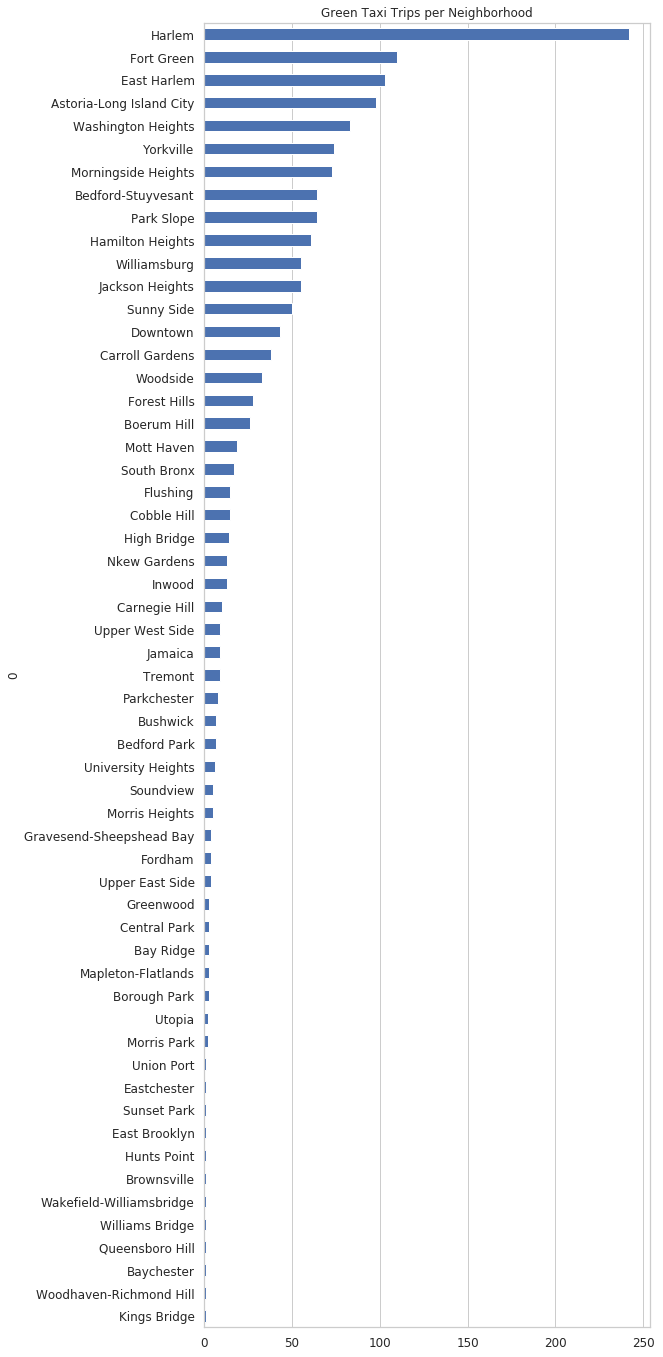

In [10]:
# We create a list consisting of neighborhood names, and counts
countsPerNeighborhood = list(map(
    lambda x: (neighborhoods['NAME'][x[0]], x[1]),
    counts.items()))

# Then we plot using pandas
df = pd.DataFrame(countsPerNeighborhood).sort_values(1).set_index(0)
ax = df.plot(kind='barh', title='Green Taxi Trips per Neighborhood', 
             figsize=(8,24), fontsize=12, legend=False)
ax.yaxis.grid(False)

In [11]:
# We perform the same task using Spark. Here we run the task in
# parallel on each partition (chunk of data). For each task, we
# have to re-create the R-Tree since the index cannot be shared
# across partitions. Note: we have to import the package inside
# processTrips() to respect the closure property.

def processTrips(pid, records):
    if pid==0:
        next(records)
    counts = {}
    import rtree
    reader = csv.reader(records)
    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    shapefile = 'ZillowNeighborhoods-NY/ZillowNeighborhoods-NY.shp'
    neighborhoods = gpd.read_file(shapefile).to_crs(fiona.crs.from_epsg(2263))
    index = rtree.Rtree()
    for idx,geometry in enumerate(neighborhoods.geometry):
        index.insert(idx, geometry.bounds)
    for row in reader:
        pdt = row[0].split(' ')[1].split(':')[0]
        if pdt!='10':
            continue
        p = geom.Point(proj(float(row[3]), float(row[2])))
        match = None
        for idx in index.intersection((p.x, p.y, p.x, p.y)):
            shape = neighborhoods.geometry[idx]
            if shape.contains(p):
                match = idx
                break
        if match:
            counts[match] = counts.get(match, 0) + 1
    return counts.items()
            
rdd = sc.textFile('green.csv')
counts = rdd.mapPartitionsWithIndex(processTrips) \
            .reduceByKey(lambda x,y: x+y) \
    .collect()
len(counts)


57

In [14]:
# It's usually better to factor things out for readability

def createIndex(shapefile):
    import rtree
    import fiona.crs
    import geopandas as gpd
    zones = gpd.read_file(shapefile).to_crs(fiona.crs.from_epsg(2263))
    index = rtree.Rtree()
    for idx,geometry in enumerate(zones.geometry):
        index.insert(idx, geometry.bounds)
    return (index, zones)

def findZone(p, index, zones):
    match = index.intersection((p.x, p.y, p.x, p.y))
    for idx in match:
        if zones.geometry[idx].contains(p):
            return idx
    return None

def processTrips(pid, records):
    import csv
    import pyproj
    import shapely.geometry as geom
    
    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    
    index, zones = createIndex('ZillowNeighborhoods-NY/ZillowNeighborhoods-NY.shp')    
    
    if pid==0:
        next(records)
    reader = csv.reader(records)
    counts = {}
    
    for row in reader:
        pdt = row[0].split(' ')[1].split(':')[0]
        if pdt!='10':
            continue
        p = geom.Point(proj(float(row[3]), float(row[2])))
        zone = findZone(p, index, zones)
        if zone:
            counts[zone] = counts.get(zone, 0) + 1
    return counts.items()
            
rdd = sc.textFile('green.csv')
counts = rdd.mapPartitionsWithIndex(processTrips) \
            .reduceByKey(lambda x,y: x+y) \
            .collect()
len(counts)


57

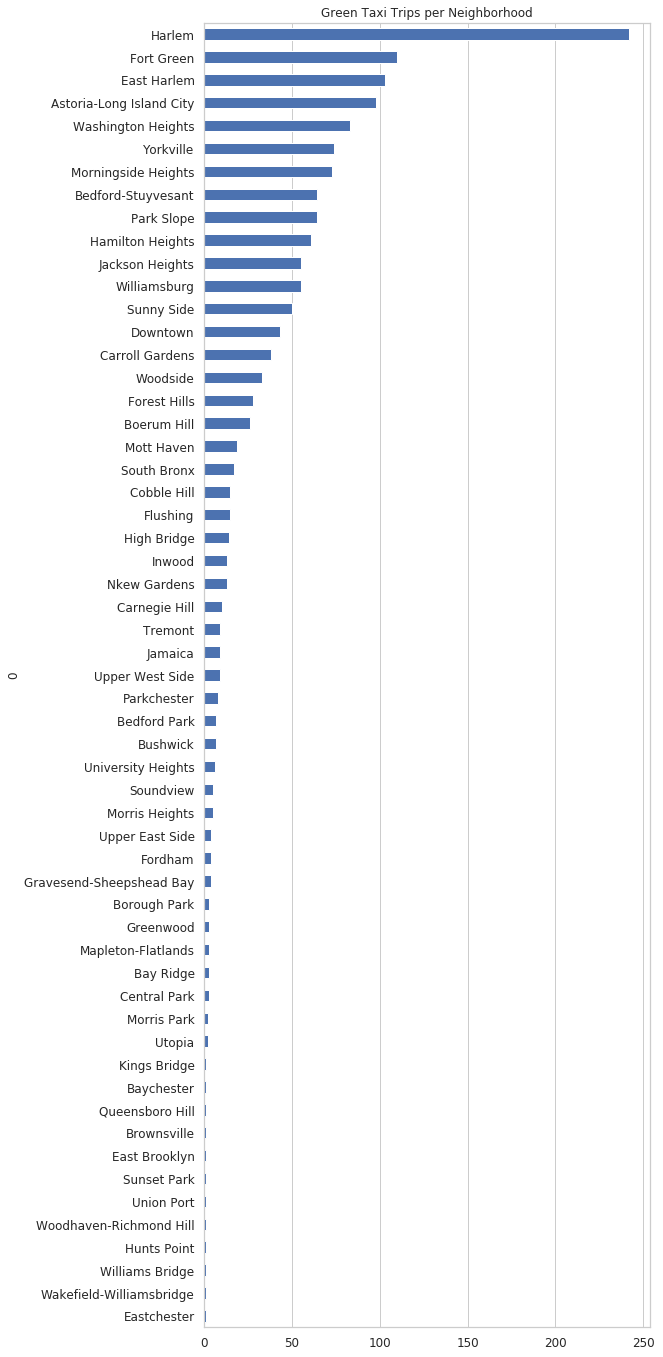

In [13]:
countsPerNeighborhood = list(map(lambda x: (neighborhoods['NAME'][x[0]], x[1]), counts))
df = pd.DataFrame(countsPerNeighborhood).sort_values(1).set_index(0)
ax = df.plot(kind='barh', title='Green Taxi Trips per Neighborhood', figsize=(8,24), fontsize=12, legend=False)
ax.yaxis.grid(False)

In [5]:
"0.0" in["0.01","2.2"]

False